<a href="https://colab.research.google.com/github/shahin1009/EDMD/blob/main/SINDYMPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPC applied to LOTKA-VOLTERRA system using a SINDYc model for different prediction horizon lengths.

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

# SINDYc methods:

Building the library of observables

In [310]:
def buildTheta(yin, nVars, polyorder):

    """
    Builds a polynomial dictionary from input data.

    Args:
        yin: Input data.
        nVars: Number of input variables.
        polyorder: Polynomial order.

    Returns:
        Polynomial dictionary.
    """

    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, 1))
    yout[:, ind] = np.ones((1,n))
    ind += 1

    # Copy input variables to output
    for i in np.arange(nVars):
        # yout[:, ind] = yin[:, i]
        yout = np.append(yout, yin[:, i].reshape(-1, 1), 1)

        ind += 1

    if polyorder >= 2:
        # Polynomial order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = yin[:, i] * yin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
                ind += 1

    if polyorder >= 3:
        # Polynomial order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = yin[:, i] * yin[:, j] * yin[:, k]
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
                    ind += 1

    if polyorder >= 4:
        # Polynomial order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = yin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
                        ind += 1


    return yout


In [311]:
# For printing purposes
def poolDataLIST(yin, ahat, nVars, polyorder):

    ind = 0
    yout = []
    yout.append(['1'])
    ind += 1

    for i in range(nVars):
        yout.append([yin[i]])
        ind += 1

    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout.append([yin[i], yin[j]])
                ind += 1

    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout.append([yin[i], yin[j], yin[k]])
                    ind += 1

    if polyorder >= 4:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k, nVars):
                        yout.append([yin[i], yin[j], yin[k], yin[l]])
                        ind += 1

    if polyorder >= 5:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k, nVars):
                        for m in range(l, nVars):
                            yout.append([yin[i], yin[j], yin[k], yin[l], yin[m]])
                            ind += 1

    output = yout

    for item1, item2 in zip(output, ahat):
      print(f'{item1}\t{item2}'.replace(", ", "").replace("'", ""))
    return output


sparsity-promoting regression using least square

In [312]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

# Data generation

### Lotka-Volterra system

In [313]:
def forcing(t):
    return (2 * (np.sin(1 * t) + np.sin(0.1 * t)))**2


def ff(t,q):   # with forcing -  Without control
    x, y = q
    a = .5
    b = .025
    d = .005
    g = .5
    return np.array([a*x-b*x*y, d*x*y-g*y+forcing(t)])

def fff(t,q,u,p):    # with forcing -  With control
    x, y = q
    a = .5
    b = .025
    d = .005
    g = .5
    return np.array([a*x-b*x*y, d*x*y-g*y+u+forcing(t)])


def solve(f , ic,t,dt):
    # rk45 solution
    sol = solve_ivp(
    f,
    t,
    ic,
    max_step = dt)

    return sol.t , sol.y

In [314]:
x0 = np.array([60, 50])
dt = .01

tf , yf = solve(ff,x0,[0,100],dt)
uf = forcing(tf)

yfnew = np.concatenate((yf, uf.reshape(1, -1)), axis=0)   # Adding u column to the population data

In [315]:
# add noise to data
dy = ff(tf , [yf[0,:],yf[1,:]],)
dynew = np.concatenate((dy, np.zeros((10001,1)).T), axis=0)
noise_mean = 0  # Mean of the noise
noise_std = 0.1  # Standard deviation of the noise
noise = np.random.normal(noise_mean, noise_std, dynew.shape)
dynew = dynew + noise

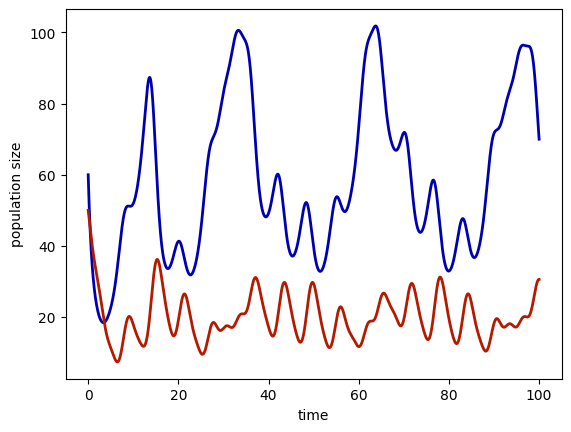

In [316]:
fig, ax1 = plt.subplots()  # Create a figure with two subplots

ax1.plot(tf,yfnew[0, :], '-', color=[0, 0, 0.7], linewidth=2)
ax1.plot(tf,yfnew[1, :], '-', color=[0.7, 0.1, 0], linewidth=2)
ax1.set_xlabel('time')
ax1.set_ylabel('population size')
plt.show()


In [317]:
nvar = 3
polyorder = 3
Theta = buildTheta(yfnew.T, nvar, polyorder)

lamb = 0.001 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dynew.T,lamb,nvar)

output = poolDataLIST(['x','y','u'], Xi, nvar, polyorder)

[1]	[-0.00173631 -0.00620737  0.        ]
[x]	[0.50000115 0.         0.        ]
[y]	[ 0.         -0.49978409  0.        ]
[u]	[0.         1.00000226 0.        ]
[xx]	[0. 0. 0.]
[xy]	[-0.025      0.0050007  0.       ]
[xu]	[0. 0. 0.]
[yy]	[0. 0. 0.]
[yu]	[0. 0. 0.]
[uu]	[0. 0. 0.]
[xxx]	[0. 0. 0.]
[xxy]	[0. 0. 0.]
[xxu]	[0. 0. 0.]
[xyy]	[0. 0. 0.]
[xyu]	[0. 0. 0.]
[xuu]	[0. 0. 0.]
[yyy]	[0. 0. 0.]
[yyu]	[0. 0. 0.]
[yuu]	[0. 0. 0.]
[uuu]	[0. 0. 0.]


# MPC with SINDY
integration method

In [318]:
# Runge–Kutta
def rk4u(v, x, u, h, n, t, p):
    for i in range(n):
        k1 = v(t, x, u, p)
        k2 = v(t, x + h/2*k1, u, p)
        k3 = v(t, x + h/2*k2, u, p)
        k4 = v(t, x + h*k3, u, p)
        x = x + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return x

prediction of future states

In [319]:
# Sindy Prediction
def sparseGalerkinControl_Discrete(t, y, u, p):

    polyorder = p['polyorder']
    ahat = p['ahat']
    y_u = np.concatenate((y, u), axis=None)
    y_u = np.reshape(y_u, (1, -1))


    yPool = buildTheta(y_u, p['nvar'], polyorder)
    ykplus1 = np.dot(yPool, ahat)
    return ykplus1[0]


test

In [320]:
# sparseGalerkinControl_Discrete test

# pest = {}
# pest['ahat'] = Xi[:,0:2]
# pest['polyorder'] = polyorder
# pest['nvar'] = nvar
# y = np.array([20,30])
# u = 16
# t = 0
# sparseGalerkinControl_Discrete(t, y, u, pest)

In [321]:
# Objective function
def lotkaObjectiveFCN(u, x, Ts, N, xref, u0, p, Q, R, Ru):
    xk = x
    uk = u[0]
    J = 0

    for ct in np.arange(N):
        # Obtain plant state at next prediction step

        # xk1 = rk4u(sparseGalerkinControl_Discrete, xk, uk, Ts, 1, [], p)
        sol = solve_ivp(
          sparseGalerkinControl_Discrete,
          [0, 0.1],
          xk,
          args = (uk,p),
          max_step = 0.1)

        xk1 = sol.y[:,-1]

        # Accumulate state tracking cost from x(k+1) to x(k+N)
        J = J + (xk1 - xref) @ Q @ np.transpose(xk1 - xref)

        # Accumulate MV rate of change cost from u(k) to u(k+N-1)
        if ct == 0:
            # J = J + np.transpose(uk - u0) @ R @ (uk - u0) + np.transpose(uk) @ Ru @ uk
            J = J + (uk - u0) * R * (uk - u0) + uk * Ru * uk

        else:
            # J = J + np.transpose(uk - u[ct-1]) @ R @ (uk - u[ct-1]) + np.transpose(uk) @ Ru @ uk

            J = J + (uk - u[ct-1]) * R * (uk - u[ct-1]) + uk * Ru * uk
        # Update xk and uk for the next prediction step
        xk = xk1
        if ct < N - 1:
            uk = u[ct + 1]

    return J.item()

test

In [322]:
# lotkaObjectiveFCN test

# pest = {}
# pest['ahat'] = Xi[:,0:2]
# pest['polyorder'] = polyorder
# pest['nvar'] = nvar
# u = np.array([[0.6],[0.5],[0.4],[0.3]])
# x = np.array([[86],[10]])
# Ts = 0.1
# N = 4
# xref = np.array([[100],[20]])
# u0 = 0.7
# Q = np.array([[1 , 0],[0 , 0]])
# R = 0.5
# Ru = 0.5
# lotkaObjectiveFCN(u, x, Ts, N, xref, u0, pest, Q, R, Ru)

Constraint function to specify lower bound population of pray

In [323]:
def lotkaConstraintFCN(u, x, Ts, N, p):
    zMin = 10                            # minimum population size
    c = np.zeros((N))
    xk = x
    uk = u[0]
    for ct in np.arange(N):

        # xk1 = rk4u(sparseGalerkinControl_Discrete, xk, uk, Ts, 1, [], p)
        sol = solve_ivp(
          sparseGalerkinControl_Discrete,
          [0, 0.1],
          xk,
          args = (uk,p),
          max_step = 0.1)

        xk1 = sol.y[:,-1]
        c[ct] = xk1[1] - zMin            # inequality constraint which should be more than zero
        xk = xk1
        if ct < N - 1:
            uk = u[ct + 1]

    return c

test

In [324]:
# lotkaConstraintFCN test

# pest = {}
# pest['ahat'] = Xi[:,0:2]
# pest['polyorder'] = polyorder
# pest['nvar'] = nvar
# u = np.array([[0.6],[0.5],[0.4],[0.3]])
# x = np.array([[86],[10]])
# Ts = 0.1
# N = 4

# lotkaConstraintFCN(u, x, Ts, N, pest)

# SINDY-MPC Algorithm

In [325]:
pest = {}
pest['ahat'] = Xi[:,0:2]
pest['polyorder'] = polyorder
pest['nvar'] = nvar


Ts = 0.1              # Time step
N = 25                # Control Horizen
Duration = 50
Nvar = 2

# Weight matrices
Q = np.array([1,0])
R = 0.5
Ru = 0.5

# initial state
x0n=np.array([60,50])
uopt0 = 0

a = .5
b = .025
d = .005
g = .5


xref1=np.array([g/d,a/b])

# Start simulation
print('Simulation started. It might take a while...')
x = x0n
Ton = 15  # Time when control starts
uopt = uopt0 * np.ones(N)
xHistory = np.array([x])  # Stores state history
uHistory = np.array([uopt[0]])  # Stores control history
tHistory = np.array([0])  # Stores time history
jHistory = np.array([0])  # Stores cost history


for ct in np.arange(int(Duration / Ts)):  # For each iteration: take measurements & optimize control input & apply control input

    if ct % 20 == 0:
      print(f'iteration #: {ct}')

    if ct * Ts > Ton:  # Turn control on
        if ct * Ts == Ton:
            print('Start control.')

        # Set references
        xref = xref1

        # Define the constraints
        cons = {'type': 'ineq',
       'fun': lotkaConstraintFCN,
       'args': (x, Ts, N, pest)}


        # Find Optimum u
        optans = minimize(
            lotkaObjectiveFCN,
            uopt,
            args = (x, Ts, N, xref, uopt[0], pest, np.diag(Q), R, Ru),
            method='SLSQP',
            constraints=cons,
            tol=1e-3
            )


        uopt= optans.x
        j = optans.fun


    else:  # If control is off
        uopt = uopt0 * np.ones(N)
        j=0


    # x = rk4u(fff, x, uopt[0], Ts, 1, ct*Ts , pest)  # step forward with optimal control
    sol = solve_ivp(
      fff,
      [ct * Ts-0.1, ct * Ts],
      x,
      args = (uopt[0],pest),
      max_step = 0.1)

    x = sol.y[:,-1]

    xHistory = np.append(xHistory, [x], axis=0) # # Stores state history
    uHistory = np.append(uHistory, [uopt[0]]) # Stores control history
    tHistory = np.append(tHistory, [tHistory[-1] + Ts / 1]) # Stores time history
    jHistory = np.append(jHistory, [j], axis=0) # Stores cost history

print('Simulation finished!')

Simulation started. It might take a while...
iteration #: 0
iteration #: 20
iteration #: 40
iteration #: 60
iteration #: 80
iteration #: 100
iteration #: 120
iteration #: 140
iteration #: 160
iteration #: 180
iteration #: 200
iteration #: 220
iteration #: 240
iteration #: 260
iteration #: 280
iteration #: 300
iteration #: 320
iteration #: 340
iteration #: 360
iteration #: 380
iteration #: 400
iteration #: 420
iteration #: 440
iteration #: 460
iteration #: 480
Simulation finished!


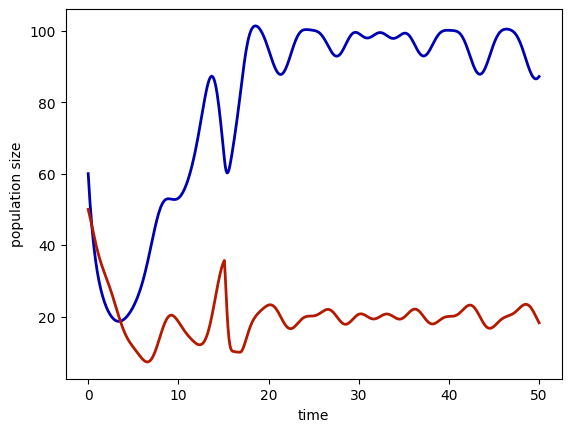

In [326]:
fig, ax1 = plt.subplots()
ax1.plot(tHistory,xHistory[:,0], '-', color=[0, 0, 0.7], linewidth=2)
ax1.plot(tHistory,xHistory[:,1], '-', color=[0.7, 0.1, 0], linewidth=2)
ax1.set_xlabel('time')
ax1.set_ylabel('population size')
plt.show()

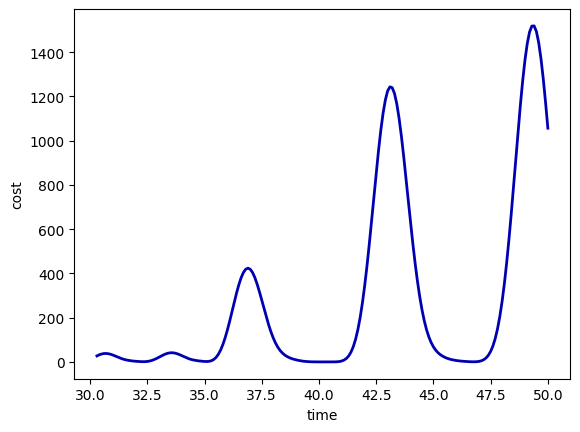

In [327]:
fig, ax2 = plt.subplots()
t = np.linspace(0, 100, 1000)
ax2.plot(tHistory[303:],jHistory[303:], '-', color=[0, 0, 0.7], linewidth=2)
ax2.set_xlabel('time')
ax2.set_ylabel('cost')
plt.show()